### **Modelado de colas de espera en un hospital público de Guatemala**

CC3039 - Modelación y Simulación

Stefano Aragoni, Luis Diego Santos, Carol Arevalo

--------------

#### *Introducción*

El sistema de salud pública en Guatemala, como en muchos otros países, enfrenta desafíos significativos. Uno de los más críticos es la prolongada espera que los pacientes deben soportar antes de recibir atención médica. Estas colas de espera pueden tener consecuencias graves, incluida una atención médica de menor calidad y una experiencia del paciente desfavorable. Este proyecto busca abordar este problema a través de técnicas avanzadas de modelado y simulación.

--------------

#### *Hospital Roosevelt de Guatemala*

El Hospital Roosevelt comenzó su construcción en 1944 en lo que antes era la finca "La Esperanza". Sin embargo, no fue sino hasta 1945 que abrió oficialmente sus puertas. Gracias al generoso apoyo internacional, este hospital experimentó un rápido crecimiento. Para agosto de 1945, ya se había planificado la expansión de su capacidad a 1,000 camas y la creación de una Escuela de Enfermería. Este hospital guatemalteco se convirtió en un importante referente de la atención médica en la región. Sin embargo, con el paso del tiempo, comenzó a enfrentar desafíos, como la falta de suministros y largos tiempos de espera, lo que afectó la calidad de la atención médica que podía brindar.


En la actualidad, el Hospital Roosevelt ha enfrentado retos significativos, como los presentados por la pandemia de COVID-19. En junio de 2020, médicos del hospital denunciaron que la capacidad para atender a pacientes con coronavirus había sido sobrepasada, tratando a unos 150 pacientes al día en un espacio diseñado para 100, todos en estado crítico. La saturación del hospital ha llegado a tal punto que se ha tenido que recurrir a la ayuda de especialistas de otras áreas y ha habido momentos en que los pacientes han debido ser atendidos en el suelo por falta de espacio. Además, los médicos expresaron su preocupación por la posible falta futura de insumos médicos, dado que el equipo de protección personal se había calculado para una afluencia menor de pacientes. Esta situación refleja los desafíos que el Hospital Roosevelt y, por extensión, el sistema de salud pública en Guatemala, enfrentan para proporcionar atención oportuna y adecuada a su población.



----------

#### *Estadísticas del Hospital Roosevelt*

Para poder desarrollar este proyecto, fue necesario determinar ciertos aspectos del Hospital Roosevelt, como su capacidad, y el número de pacientes que atiende. Para ello, se realizó una investigación en la que se recopilaron datos de diversas fuentes, como el Ministerio de Salud Pública y Asistencia Social (MSPAS), y el Hospital Roosevelt. A continuación, se presentan los resultados obtenidos.

- Cuenta con tres emergencias maternidad, adultos y pediatria
- Tiene capacidad para 950 pacientes en cama
- Se tine una capcidad de 65 pacientes en el area de emergencias
- Hay 9 camas para observación, 20 bancas para inhaloterapia y 5 cuartos de shock.
- Diariamente atienden a un promedio de 400 pacientes en urgencias.
    - El 20% requieren atención inmediata.
    - El 70% atienden por enfermedades comunes.

A través de una investigación realizada por Prensa Libre se logró obtener el protocolo que se sigue cuando un paciente entra a urgencias. Dicha información fue proveída directamente por doctores y otros colaboradores del Hospital Roosevelt. A continuación, se presentan los puntos más relevantes de dicho protocolo.


1. Médicos evalúan si son casos que requieren atención de urgencia. 
    - Hay 4 clinicas de clasificacion. 
3. El 70% de los casos que entran a urgencias son *enfermedades comunes*.
    - Estos son tratados en la clínica. Normalmente, tratamiento dura 5 a 10 minutos.
4. Las *urgencias* son heridas, elevación de presión, deshidratación, o casos que merecen una atención mayor, estos pasan con un especialista.
    - Entre 30 a 45 minutos de atención.
5. Cuando la persona llega con una herida de arma blanca o de fuego, con traumatismo, politraumatismo o complicaciones de enfermedades crónicas, se trata de una emergencia e ingresan cuanto antes para ser tratada en el área de Traumatología, Medicina interna o Cirugía.
    - Estas personas entran a clinica de *claisificacion 1* directamente (desde ambulancias)
    - 3.3% de los casos son de este tipo.


Por último, se entrevistó a una Doctora Residente que labora en este hospital. Ella indicó que durante el día y la noche tienen la siguiente cantidad de doctores:
- 5 doctores que atienden emergencias
- 9 doctores que atienden urgencias
- 4 doctores que atienden en clínica de enfermedades comunes


Referencias:

- Ola, A. (2019). Se reduce la saturación de pacientes en las emergencias de los hospitales. Prensa Libre. https://prensalibre.com/guatemala/comunitario/se-reduce-la-saturacion-de-pacientes-en-las-emergencias-de-los-hospitales/.
- Hospital Roosevelt. (2016). Hospital Roosevelt conmemora 61 años de Aniversario - Hospital Roosevelt. Hospitalroosevelt. https://hospitalroosevelt.gob.gt/hospital-roosevelt-conmemora-61-anos-de-aniversario/.
- Hospital Roosevelt. (2017). Acerca de Hospital Roosevelt. Hospitalroosevelt. https://hospitalroosevelt.com/acerca-de-hospital-roosevelt/.

----------

### *Simulación del flujo de pacientes en urgencias en el Hospital Roosevelt de Guatemala*

Con los valores anteriormente mencionados, se procedió a realizar la simulación del flujo de pacientes en urgencias en el Hospital Roosevelt de Guatemala. Esto con el propósito de determinar el tiempo de espera promedio que un paciente debe soportar antes de ser atendido por un médico.

Asimismo, se tiene como objetivo determinar cómo alterar ciertos parámetros del sistema para reducir el tiempo de espera promedio de los pacientes. Para ello, se realizarán simulaciones con diferentes valores de los parámetros y se compararán los resultados obtenidos.

*Asunciones:*

- El hospital está abierto las 24 horas del día.
- Siempre hay la misma cantidad de doctores en cada área del hospital simulada. 

##### *1. Definiciones y Parámetros Iniciales*

Como primer paso, se definieron las siguientes variables y parámetros iniciales:

In [1]:
from mesa import Agent
from mesa import Model
from mesa.time import RandomActivation
import random
from matplotlib import pyplot as plt

# Capacidades y parámetros del hospital
CAPACIDAD_EMERGENCIAS = 65
PACIENTES_POR_DIA = 400                              

# Probabilidades para clasificación
PORCENTAJE_URGENCIAS = 0.20                                                 # 20% de probabilidad de urgencias
PROB_EMERGENCIA = 0.033                                                     # 3.3% de probabilidad hospitalización / emergencia
PROB_ENFERMEDADES_COMUNES = 0.7                                             # 70% de probabilidad de enfermedades comunes       


# Tiempo de espera
TIEMPO_ESPERA_COMUNES = 15                                      # 15 minutos para ser atendido por enfermedades comunes
TIEMPO_ESPERA_PROMEDIO = lambda: random.randint(45, 3*60)       # 45 minutos a 3 horas para ser atendido por urgencias


##### *2. Funciones de Simulación*

Posteriormente, se definieron clases y funciones base de la simulación. 

Las primeras clases que se definieron fueron aquellas que representan las diferentes clínicas y áreas de atención del hospital. Estas clases heredan de la clase **Clinica**.

Estas clínicas buscan simular el proceso de clasificación de pacientes que se realiza en el Hospital Roosevelt. Asimismo, se busca simular la asignación del orden de atención de los pacientes, dependiendo de su clasificación. Finalmente, también se logra simular el proceso de atención de los pacientes por parte de los médicos.

In [3]:
class Clinica(Agent):
    def __init__(self, unique_id, model, capacidad=1):
        super().__init__(unique_id, model)
        self.capacidad = capacidad                  # Capacidad de la clínica
        self.pacientes_actualmente = 0              # Pacientes actualmente en la clínica
        self.tiempo_espera_promedio = 0             # Tiempo de espera promedio de la clínica
        self.total_pacientes_atendidos = 0          # Total de pacientes atendidos en la clínica

    def atender_paciente(self, paciente):
        self.pacientes_actualmente += 1

        # Actualizamos el tiempo de espera promedio
        self.tiempo_espera_promedio = ((self.tiempo_espera_promedio * self.total_pacientes_atendidos) + paciente.tiempo_espera) / (self.total_pacientes_atendidos + 1)
        self.total_pacientes_atendidos += 1

        # Iniciar el tiempo de atención de esta clínica
        tiempo_de_atencion = self.tiempo_atencion()
        self.model.schedule_event(tipo="liberar_clinica", t=self.model.schedule.time + tiempo_de_atencion, clinica=self)

    def termino_atencion(self, paciente):
        self.liberar()                                          # Liberamos la clínica si ya terminó de atender al paciente
        return True

    def esta_disponible(self):
        return self.pacientes_actualmente < self.capacidad      # Si hay menos pacientes que la capacidad, está disponible

    def tiempo_atencion(self):
        pass                                                    # Tiempo de atención de la clínica

    def liberar(self):
        self.pacientes_actualmente -= 1                         # Liberamos la clínica de un paciente
        if self.pacientes_actualmente < 0:
            self.pacientes_actualmente = 0
        self.check_cola_espera()                                # Revisamos si hay pacientes en la cola de espera
    

    def check_cola_espera(self):                                # Revisamos si hay pacientes en la cola de espera y atiende al primero
        if isinstance(self, ClinicaEnfermedadesComunes) and self.model.cola_enfermedad_comun:
            paciente_en_espera = self.model.cola_enfermedad_comun.pop(0)
            paciente_en_espera.clinica_asignada = self
            self.atender_paciente(paciente_en_espera)
            paciente_en_espera.estado = 'enfermedad_comun'
        elif isinstance(self, ClinicaUrgencias) and self.model.cola_urgencias:
            paciente_en_espera = self.model.cola_urgencias.pop(0)
            paciente_en_espera.clinica_asignada = self
            self.atender_paciente(paciente_en_espera)
            paciente_en_espera.estado = 'urgencia'
        elif isinstance(self, ClinicaClasificacion1) and self.model.cola_clasificacion_1:
            paciente_en_espera = self.model.cola_clasificacion_1.pop(0)
            paciente_en_espera.clinica_asignada = self
            self.atender_paciente(paciente_en_espera)
            paciente_en_espera.estado = 'clasificacion_1'
            

class ClinicaEnfermedadesComunes(Clinica):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
    
    def tiempo_atencion(self):
        # Entre 10 y 15 minutos
        return random.randint(10, 15)                       # Entre 10 y 15 minutos de cita con el médico para tratamiento de enfermedades comunes
    
    def atender_paciente(self, paciente):
        tiempo_espera_actual = self.model.current_time - paciente.tiempo_llegada
        paciente.tiempo_espera += tiempo_espera_actual
        self.model.tiempo_espera_enfermedad_comun += tiempo_espera_actual
        self.pacientes_actualmente += 1
        tiempo_de_atencion = self.tiempo_atencion() 
        self.model.schedule_event(tipo="liberar_clinica", t=self.model.schedule.time + tiempo_de_atencion, clinica=self)

class ClinicaUrgencias(Clinica):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
    
    def tiempo_atencion(self):
        # Entre 30 y 45 minutos
        return random.randint(30, 45)                       # Entre 30 y 45 minutos de cita con el médico para tratamiento de urgencias
        
    def atender_paciente(self, paciente):
        tiempo_espera_actual = self.model.current_time - paciente.tiempo_llegada
        paciente.tiempo_espera += tiempo_espera_actual
        self.model.tiempo_espera_urgencias += tiempo_espera_actual
        self.pacientes_actualmente += 1
        tiempo_de_atencion = self.tiempo_atencion()
        self.model.schedule_event(tipo="liberar_clinica", t=self.model.schedule.time + tiempo_de_atencion, clinica=self)

class ClinicaClasificacion1(Clinica):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
    
    def tiempo_atencion(self):
        return random.randint(45, 120)                      # Entre 45 minutos y 2 horas para operar o tratar al paciente
    
    def atender_paciente(self, paciente):
        tiempo_espera_actual = self.model.current_time - paciente.tiempo_llegada
        paciente.tiempo_espera += tiempo_espera_actual
        self.model.tiempo_espera_clasificacion_1 += tiempo_espera_actual
        self.pacientes_actualmente += 1
        tiempo_de_atencion = self.tiempo_atencion() 
        self.model.schedule_event(tipo="liberar_clinica", t=self.model.schedule.time + tiempo_de_atencion, clinica=self)
    

class ClinicaClasificadora(Clinica):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)

    def clasificar_paciente(self):
        r = random.random()                                 # Clasifica al paciente en base a probabilidades
        if r < 0.70:
            return 'enfermedad_comun'
        elif 0.7 <= r < 0.733:
            return 'clasificacion_1'
        else:
            return 'urgencia'
        
    def tiempo_atencion(self):
        return random.randint(5, 10)                         # Entre 5 y 10 minutos para clasificar al paciente
    
    def atender_paciente(self, paciente):
        tiempo_espera_actual = self.model.current_time - paciente.tiempo_llegada
        paciente.tiempo_espera += tiempo_espera_actual
        self.model.tiempo_espera_clasificadora += tiempo_espera_actual
        self.pacientes_actualmente += 1
        tiempo_de_atencion = self.tiempo_atencion()
        self.model.schedule_event(tipo="liberar_clinica", t=self.model.schedule.time + tiempo_de_atencion, clinica=self)

    

Posteriormente, se definió la clase **Paciente, la cual contiene los atributos de cada paciente que ingresa al sistema**. Debido a que los pacientes se están tratando como agentes, se crea un objeto nuevo cada vez que un paciente ingresa al sistema.


Esta clase almacena si un paciente está siendo atendido o si está esperando a ser atendido. Asimismo, indica si el paciente entró en ambulancia. Finalmente, almacena el tiempo de espera del paciente.

In [4]:
class Paciente(Agent):
    ESPERANDO = 'entrando'
    SIENDO_ATENDIDO = 'siendo_atendido'
    FINALIZADO = 'finalizado'
    
    def __init__(self, unique_id, model, en_ambulancia=False):
        self.unique_id = unique_id                      # ID único del paciente
        self.model = model            
        self.en_ambulancia = en_ambulancia              # Si el paciente llegó en ambulancia (emergencia)
        self.tiempo_llegada = model.current_time        # Al crear un paciente, registramos el tiempo de llegada
        self.tiempo_espera = 0                          # Inicializamos el tiempo de espera en 0
        self.estado = self.ESPERANDO                    # Inicialmente, el paciente está esperando

    def esperar(self):
        if self.estado == self.ESPERANDO:
            self.tiempo_espera += 1                     # Sumamos 1 minutos a la espera

    def recibir_atencion(self):
        self.estado = self.SIENDO_ATENDIDO              # Cambiamos el estado del paciente a siendo atendido

    def finalizar(self):
        self.estado = self.FINALIZADO                   # Cambiamos el estado del paciente a finalizado 
        

    def step(self):
        self.esperar()
        
        if self.estado == self.ESPERANDO:               # Si el paciente está esperando
            
            if self.en_ambulancia:                      # Si llegó en ambulancia

                clinica_target = self.model.clinica_disponible(tipo_clinica=ClinicaClasificacion1)      # Buscamos una clínica clasificadora disponible
                if clinica_target:                                                                      # Si hay una clínica clasificadora disponible
                    self.clinica_asignada = clinica_target                              
                    self.clinica_asignada.atender_paciente(self)                                        # Asignamos la clínica al paciente
                    self.recibir_atencion()                                                             # Cambiamos el estado del paciente a siendo atendido
                    self.model.pacientes_clasificacion_1 += 1                                           # Sumamos 1 al contador de pacientes en clasificación 1

                else:
                    self.model.cola_clasificacion_1.append(self)                                        # Si no hay una clínica clasificadora disponible, agregamos al paciente a la cola de clasificación 1

            else:                                       # Si no llegó en ambulancia
                
                clinica_clasificadora_disponible = self.model.clinica_disponible(tipo_clinica=ClinicaClasificadora)     # Buscamos una clínica clasificadora disponible

                if clinica_clasificadora_disponible:                                                                    # Si hay una clínica clasificadora disponible

                    self.clinica_asignada = clinica_clasificadora_disponible                                            # Asignamos la clínica al paciente
                    self.clinica_asignada.atender_paciente(self)
                    clasificacion = self.clinica_asignada.clasificar_paciente()                                         # Clasificamos al paciente
                    self.model.pacientes_clasificadora += 1                                                             # Sumamos 1 al contador de pacientes en clasificadora

                    if clasificacion == 'enfermedad_comun':                                                             # Si el paciente es clasificado como enfermedad común
                        clinica_target = self.model.clinica_disponible(tipo_clinica=ClinicaEnfermedadesComunes)         # Buscamos una clínica de enfermedades comunes disponible
                    elif clasificacion == 'urgencia':                                                                   # Si el paciente es clasificado como urgencia
                        clinica_target = self.model.clinica_disponible(tipo_clinica=ClinicaUrgencias)                   # Buscamos una clínica de urgencias disponible
                    elif clasificacion == 'clasificacion_1':                                                            # Si el paciente es clasificado como clasificación 1
                        clinica_target = self.model.clinica_disponible(tipo_clinica=ClinicaClasificacion1)              # Buscamos una clínica de clasificación 1 disponible

                    # Paciente ya fue clasificado, ahora se le asigna una clínica para ser atendido
                    #------------------------------------#
                    self.tiempo_espera_clasificadora = self.tiempo_espera                                               # Guardamos el tiempo de espera en la clasificadora
                    self.estado = clinica_target                                                                        # Paciente ahora está esperando ser atendido por la clínica
                    self.tiempo_espera = 0                                                                              # Reiniciamos el tiempo de espera                                                                     
                    #------------------------------------#
                    
                    if clinica_target:                                                                                  # Si hay una clínica del tipo correcto disponible
                        self.clinica_asignada = clinica_target
                        self.clinica_asignada.atender_paciente(self)                                                    # Asignamos la clínica al paciente

                        if clasificacion == 'enfermedad_comun':
                            self.model.pacientes_enfermedad_comun += 1
                        elif clasificacion == 'urgencia':
                            self.model.pacientes_urgencias += 1
                        elif clasificacion == 'clasificacion_1':
                            self.model.pacientes_clasificacion_1 += 1

                        self.recibir_atencion()                                                                         # Cambiamos el estado del paciente a siendo atendido
                        
                    else:                                                                                               # Si no hay una clínica del tipo correcto disponible
                        if clasificacion == 'enfermedad_comun':
                            self.model.cola_enfermedad_comun.append(self)                                               # Agregamos al paciente a la cola correspondiente
                        elif clasificacion == 'urgencia':
                            self.model.cola_urgencias.append(self)
                        elif clasificacion == 'clasificacion_1':
                            self.model.cola_clasificacion_1.append(self)

        elif self.estado == self.SIENDO_ATENDIDO:                                               # Si el paciente está siendo atendido
            if self.clinica_asignada and self.clinica_asignada.termino_atencion(self):          # Si la clínica asignada al paciente terminó su atención
                self.finalizar()                                                                # Cambiamos el estado del paciente a finalizado


##### *3. Definición del Modelo*

Finalmente, se definió el modelo principal del Hospital Roosevelt. Este maneja la lógica global de la simulación y gestiona todos los agentes.


Más específicamente, se creó las diferentes clínicas y se definió la cantidad de pacientes que pueden ser atendidos simultáneamente en cada una. Asimismo, se definió la cantidad de pacientes que ingresan al sistema por hora. 

Finalmente, también se crearon los diferentes agentes (pacientes) que ingresan al sistema. Estos agentes se crean con un tiempo de llegada aleatorio, por lo cual van llegando durante el transcurso de la simulación. Asimismo, se les asigna una clasificación aleatoria, dependiendo de la distribución de probabilidad definida anteriormente.

In [5]:
class Event:
    def __init__(self, tipo, t, clinica):
        self.tipo = tipo
        self.t = t
        self.clinica = clinica

class HospitalModel(Model):
    def __init__(self, N, num_clinicas_clasificacion1 = 5, num_clinicas_urgencias = 9, num_clinicas_comunes = 4, num_clinicas_clasificadoras = 4):
        self.num_pacientes = N
        self.upcoming_events = []
        self.schedule = RandomActivation(self)
        self.current_time = 0  # El tiempo actual de la simulación

        # Colas de espera
        self.cola_enfermedad_comun = []
        self.cola_urgencias = []
        self.cola_clasificacion_1 = []
        self.cola_clasificadora = []

        # Iniciar contadores y acumuladores de tiempo de espera
        self.pacientes_enfermedad_comun = 0
        self.pacientes_urgencias = 0
        self.pacientes_clasificacion_1 = 0
        self.pacientes_clasificadora = 0
        self.tiempo_espera_enfermedad_comun = 0
        self.tiempo_espera_urgencias = 0
        self.tiempo_espera_clasificacion_1 = 0
        self.tiempo_espera_clasificadora = 0

        # Crear clínicas
        self.clinicas_clasificadoras = [ClinicaClasificadora(i, self) for i in range(num_clinicas_clasificadoras)]
        self.clinicas_comunes = [ClinicaEnfermedadesComunes(i, self) for i in range(num_clinicas_comunes)]
        self.clinicas_urgencias = [ClinicaUrgencias(i+len(self.clinicas_comunes), self) for i in range(num_clinicas_urgencias)]
        self.clinicas_clasificacion1 = [ClinicaClasificacion1(i+len(self.clinicas_comunes)+len(self.clinicas_urgencias), self) for i in range(num_clinicas_clasificacion1)]
        self.clinicas = self.clinicas_clasificadoras + self.clinicas_comunes + self.clinicas_urgencias + self.clinicas_clasificacion1

        # Crear pacientes
        for i in range(self.num_pacientes):
            paciente = Paciente(i, self, en_ambulancia=random.random() < 0.033)
            self.schedule.add(paciente)

    def reporte(self):
        print("Pacientes atendidos: ")
        print(f"1. Cantidad de pacientes clasificados: {self.pacientes_clasificadora}")
        print(f"2. Cantidad de pacientes de urgencias: {self.pacientes_urgencias}")
        print(f"3. Cantidad de pacientes de enfermedad común: {self.pacientes_enfermedad_comun}")
        print(f"4. Cantidad de pacientes de clasificación 1: {self.pacientes_clasificacion_1}")

        print("\nTiempo de espera promedio (minutos): ")
        print(f"1. Promedio de tiempo de espera clasificadora: {self.tiempo_espera_clasificadora/self.pacientes_clasificadora}")
        print(f"2. Promedio de tiempo de espera enfermedad común: {self.tiempo_espera_enfermedad_comun/self.pacientes_enfermedad_comun}")
        print(f"3. Promedio de tiempo de espera urgencias: {self.tiempo_espera_urgencias/self.pacientes_urgencias}")
        print(f"4. Promedio de tiempo de espera clasificación 1: {self.tiempo_espera_clasificacion_1/self.pacientes_clasificacion_1}")
        


    def schedule_event(self, tipo, t, clinica):
        # Agregar evento a la lista
        event = Event(tipo, t, clinica)
        self.upcoming_events.append(event)
        # Ordenar la lista de eventos por tiempo para ejecutar el evento más próximo primero
        self.upcoming_events.sort(key=lambda e: e.t)

    def step(self):
        # Avanza un paso en la simulación
        self.schedule.step()

        # Manejar eventos
        while self.upcoming_events:
            # Tomar el próximo evento
            event = self.upcoming_events.pop(0)
            
            # Si el evento ocurre después del tiempo de finalización, terminamos la simulación
            if event.t > 1440:
                break

            # Avanzar el tiempo
            self.current_time = event.t

            # Ejecutar el evento
            self.execute_event(event)

    def clinica_disponible(self, tipo_clinica=None):
        for clinica in self.clinicas:
            if isinstance(clinica, tipo_clinica) and clinica.esta_disponible():
                return clinica
        return None
    
    def execute_event(self, event):
        if event.tipo == "liberar_clinica":
            event.clinica.liberar()


##### *4. Ejecución*

Finalmente, se ejecutó el modelo y se obtuvieron los resultados. Para esto, se modeló un día en el hospital, con 400 pacientes que fueron ingresando en diferentes momentos del día.

A continuación, se presentan los resultados obtenidos.

Pacientes atendidos: 
1. Cantidad de pacientes clasificados: 386
2. Cantidad de pacientes de urgencias: 103
3. Cantidad de pacientes de enfermedad común: 270
4. Cantidad de pacientes de clasificación 1: 18

Tiempo de espera promedio (minutos): 
1. Promedio de tiempo de espera clasificadora: 86.65803108808291
2. Promedio de tiempo de espera enfermedad común: 86.96666666666667
3. Promedio de tiempo de espera urgencias: 87.49514563106796
4. Promedio de tiempo de espera clasificación 1: 89.83333333333333


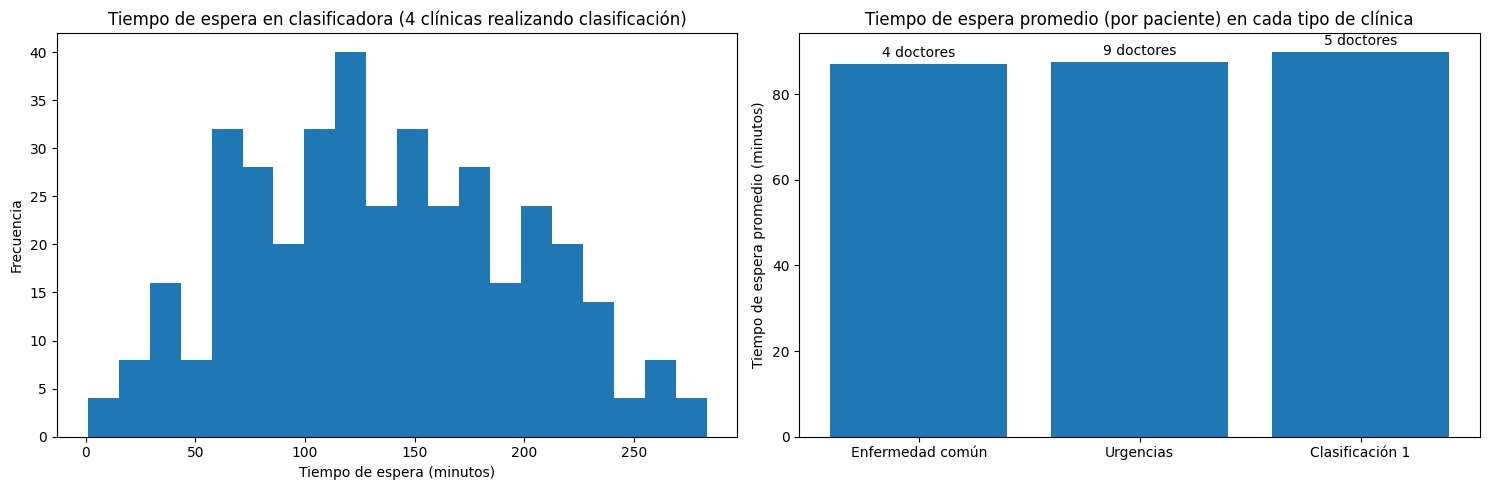

In [6]:
model = HospitalModel(400)  

for i in range(1440):  
    model.step()

model.reporte()

# Creación de la figura y los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Grafica: Tiempo de espera en clasificadora (pacientes que no llegaron en ambulancia)
tiempos_espera_clasificadora = [p.tiempo_espera_clasificadora for p in model.schedule.agents if not p.en_ambulancia]
ax1.hist(tiempos_espera_clasificadora, bins=20)
ax1.set_xlabel("Tiempo de espera (minutos)")
ax1.set_ylabel("Frecuencia")
ax1.set_title("Tiempo de espera en clasificadora (4 clínicas realizando clasificación)")

# Grafica: Barras de tiempo promedio de espera en cada tipo de clínica
tiempos_espera_clinicas = [model.tiempo_espera_enfermedad_comun/model.pacientes_enfermedad_comun, model.tiempo_espera_urgencias/model.pacientes_urgencias, model.tiempo_espera_clasificacion_1/model.pacientes_clasificacion_1]
doctores_por_clinica = [4, 9, 5]

barras = ax2.bar(["Enfermedad común", "Urgencias", "Clasificación 1"], tiempos_espera_clinicas)
ax2.set_ylabel("Tiempo de espera promedio (minutos)")
ax2.set_title("Tiempo de espera promedio (por paciente) en cada tipo de clínica")

# Anotaciones de la cantidad de doctores por clínica
for barra, doctores in zip(barras, doctores_por_clinica):
    altura = barra.get_height()
    ax2.annotate(f'{doctores} doctores',
                 xy=(barra.get_x() + barra.get_width() / 2, altura),
                 xytext=(0, 3),  # 3 puntos de desplazamiento vertical
                 textcoords="offset points",
                 ha='center', va='bottom')

# Mostrar la figura completa
plt.tight_layout()
plt.show()

Para intentar reducir el tiempo de espera promedio de los pacientes, se realizaron simulaciones con diferentes valores de los parámetros.

Entre una de las pruebas realizadas, se intentó reducir el tiempo de espera promedio de los pacientes aumentando la cantidad de doctores disponibles en el hospital. Para esto, se duplicó la cantidad de doctores disponibles en el hospital. A continuación, se presentan los resultados obtenidos.

En este caso, se pudo observar que duplicar la cantidad de clínicas clasificadoras iniciales permitió que ninguna persona esperara más de 200 minutos. Esto a diferencia de las 4 clínicas iniciales, donde el tiempo de espera máximo fue arriba de 250 minutos.

En el caso de los pacientes que ingresaron en ambulancia y que fueron atendidos en Clasificación 1, se pudo observar que el tiempo de espera promedio se redujo de 85 minutos a 39 minutos. Esto representa una reducción del más del 50% en el tiempo de espera promedio de estos pacientes. Por lo tanto, se recomienda al Ministerio de Salud Pública y Asistencia Social (MSPAS) que se duplique la cantidad de doctores de emergencia actual.

Sin embargo, en el caso de pacientes con enfermedades comunes y urgencias, no se observó una reducción significativa en el tiempo de espera promedio. Estas estaban en 88 y 90 minutos, respectivamente, y se redujeron a 69 y 70

Esto a pesar de haber duplicado la cantidad de doctores disponibles para atender a estos pacientes. Debido a esto, se realizarán otras pruebas para intentar reducir el tiempo de espera promedio de estos pacientes.

Pacientes atendidos: 
1. Cantidad de pacientes clasificados: 389
2. Cantidad de pacientes de urgencias: 108
3. Cantidad de pacientes de enfermedad común: 269
4. Cantidad de pacientes de clasificación 1: 22

Tiempo de espera promedio (minutos): 
1. Promedio de tiempo de espera clasificadora: 72.08740359897172
2. Promedio de tiempo de espera enfermedad común: 71.2081784386617
3. Promedio de tiempo de espera urgencias: 72.87037037037037
4. Promedio de tiempo de espera clasificación 1: 48.36363636363637


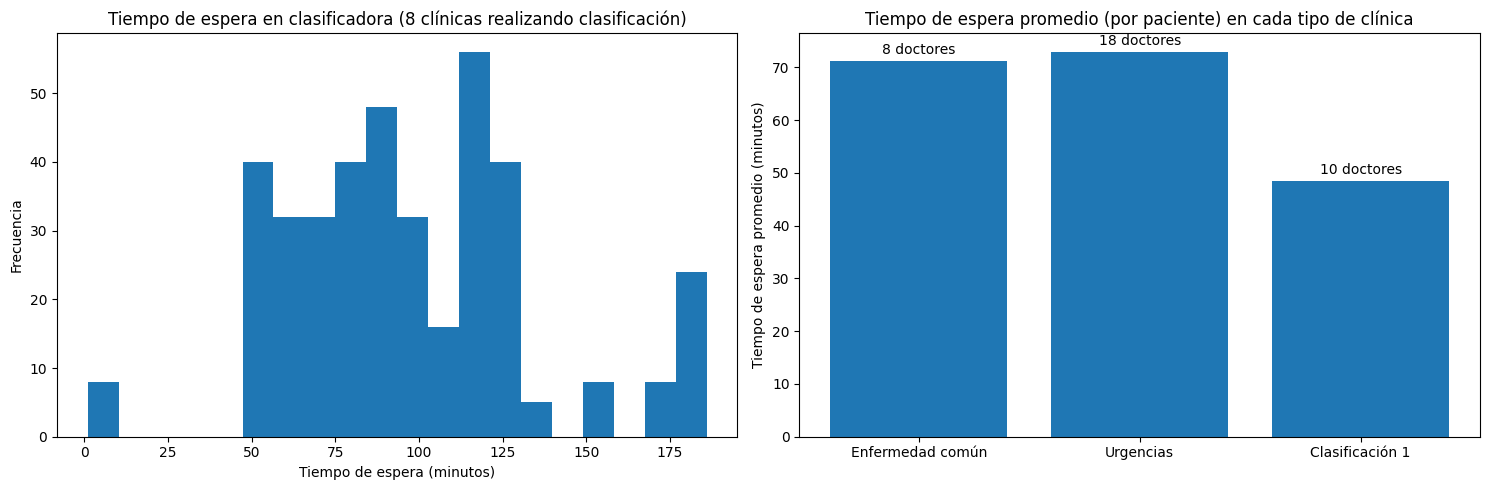

In [7]:
num_clinicas_clasificacion1 = 10
num_clinicas_urgencias = 18
num_clinicas_comunes = 8
num_clinicas_clasificadoras = 8

model = HospitalModel(400, num_clinicas_clasificacion1, num_clinicas_urgencias, num_clinicas_comunes, num_clinicas_clasificadoras)

for i in range(1440):  
    model.step()

model.reporte()

# Creación de la figura y los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Grafica: Tiempo de espera en clasificadora (pacientes que no llegaron en ambulancia)
tiempos_espera_clasificadora = [p.tiempo_espera_clasificadora for p in model.schedule.agents if not p.en_ambulancia]
ax1.hist(tiempos_espera_clasificadora, bins=20)
ax1.set_xlabel("Tiempo de espera (minutos)")
ax1.set_ylabel("Frecuencia")
ax1.set_title("Tiempo de espera en clasificadora (8 clínicas realizando clasificación)")

# Grafica: Barras de tiempo promedio de espera en cada tipo de clínica
tiempos_espera_clinicas = [model.tiempo_espera_enfermedad_comun/model.pacientes_enfermedad_comun, model.tiempo_espera_urgencias/model.pacientes_urgencias, model.tiempo_espera_clasificacion_1/model.pacientes_clasificacion_1]
doctores_por_clinica = [8, 18, 10]

barras = ax2.bar(["Enfermedad común", "Urgencias", "Clasificación 1"], tiempos_espera_clinicas)
ax2.set_ylabel("Tiempo de espera promedio (minutos)")
ax2.set_title("Tiempo de espera promedio (por paciente) en cada tipo de clínica")

# Anotaciones de la cantidad de doctores por clínica
for barra, doctores in zip(barras, doctores_por_clinica):
    altura = barra.get_height()
    ax2.annotate(f'{doctores} doctores',
                 xy=(barra.get_x() + barra.get_width() / 2, altura),
                 xytext=(0, 3),  # 3 puntos de desplazamiento vertical
                 textcoords="offset points",
                 ha='center', va='bottom')

# Mostrar la figura completa
plt.tight_layout()
plt.show()

Después de una serie de pruebas, se logró determinar que con 13 doctores de urgencias (incremento de 4 doctores) y 7 doctoras de enfermedades comunes (incremento de 3 doctores) se logró reducir el tiempo de espera promedio de estos pacientes de forma similar si se tuvieran 18 y 8 doctores, respectivamente.

Es claro que al incrementar la cantidad de doctores disponibles en el hospital, se logra reducir el tiempo de espera promedio de los pacientes. Sin embargo, esto no es una solución sostenible, ya que se requiere de una gran cantidad de doctores para lograr una reducción significativa en el tiempo de espera promedio de los pacientes. Por lo tanto, con este último acercamiento se busca incrementar la cantidad de doctores de forma más realista pero que siga reduciendo el tiempo de espera promedio de los pacientes.

Pacientes atendidos: 
1. Cantidad de pacientes clasificados: 386
2. Cantidad de pacientes de urgencias: 101
3. Cantidad de pacientes de enfermedad común: 273
4. Cantidad de pacientes de clasificación 1: 20

Tiempo de espera promedio (minutos): 
1. Promedio de tiempo de espera clasificadora: 71.00518134715026
2. Promedio de tiempo de espera enfermedad común: 70.88278388278388
3. Promedio de tiempo de espera urgencias: 73.16831683168317
4. Promedio de tiempo de espera clasificación 1: 47.45


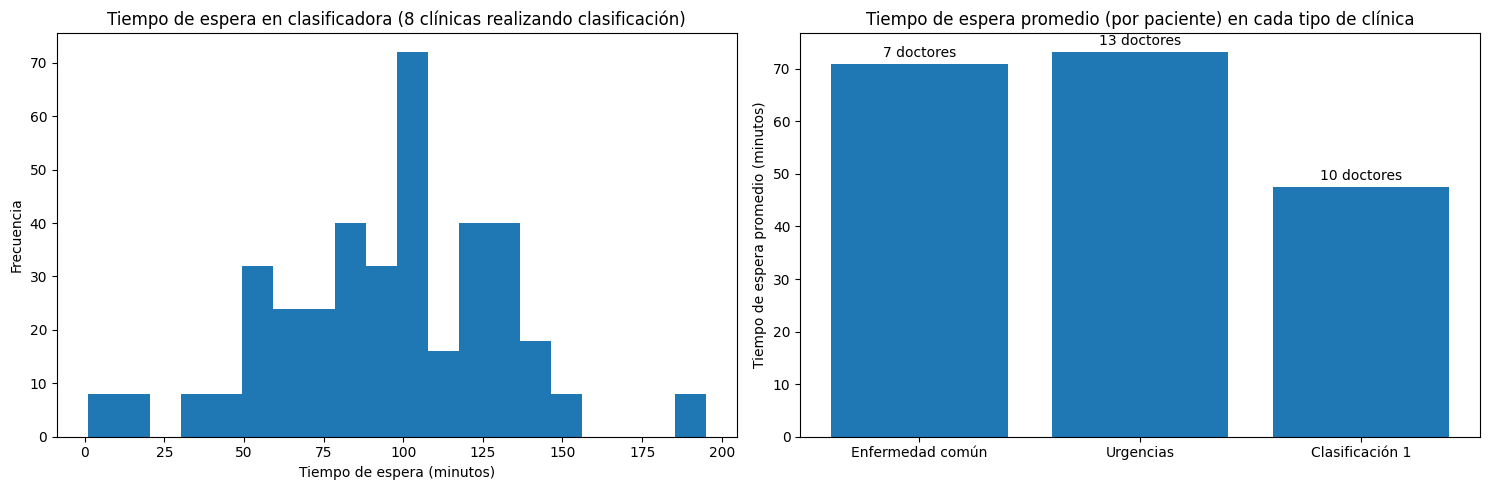

In [19]:
num_clinicas_clasificacion1 = 10
num_clinicas_clasificadoras = 8

num_clinicas_urgencias = 13
num_clinicas_comunes = 7


model = HospitalModel(400, num_clinicas_clasificacion1, num_clinicas_urgencias, num_clinicas_comunes, num_clinicas_clasificadoras)

for i in range(1440):  
    model.step()

model.reporte()

# Creación de la figura y los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Grafica: Tiempo de espera en clasificadora (pacientes que no llegaron en ambulancia)
tiempos_espera_clasificadora = [p.tiempo_espera_clasificadora for p in model.schedule.agents if not p.en_ambulancia]
ax1.hist(tiempos_espera_clasificadora, bins=20)
ax1.set_xlabel("Tiempo de espera (minutos)")
ax1.set_ylabel("Frecuencia")
ax1.set_title("Tiempo de espera en clasificadora (8 clínicas realizando clasificación)")

# Grafica: Barras de tiempo promedio de espera en cada tipo de clínica
tiempos_espera_clinicas = [model.tiempo_espera_enfermedad_comun/model.pacientes_enfermedad_comun, model.tiempo_espera_urgencias/model.pacientes_urgencias, model.tiempo_espera_clasificacion_1/model.pacientes_clasificacion_1]
doctores_por_clinica = [7, 13, 10]

barras = ax2.bar(["Enfermedad común", "Urgencias", "Clasificación 1"], tiempos_espera_clinicas)
ax2.set_ylabel("Tiempo de espera promedio (minutos)")
ax2.set_title("Tiempo de espera promedio (por paciente) en cada tipo de clínica")

# Anotaciones de la cantidad de doctores por clínica
for barra, doctores in zip(barras, doctores_por_clinica):
    altura = barra.get_height()
    ax2.annotate(f'{doctores} doctores',
                 xy=(barra.get_x() + barra.get_width() / 2, altura),
                 xytext=(0, 3),  # 3 puntos de desplazamiento vertical
                 textcoords="offset points",
                 ha='center', va='bottom')

# Mostrar la figura completa
plt.tight_layout()
plt.show()

Finalmente, se quiso determinar el tiempo de espera en el Hospital Roosevelt si se tuviera la cantidad de doctores que hay un Hospital promedio de Estados Unidos. Para esto, se investigó y se encontró la siguiente información:

- 7 doctores de emergencias (cirujanos)
- 5 doctores de urgencias
- 15 doctores de enfermedades comunes
- 10 doctores clasificadores (incluyendo internistas, residentes, enfermeres y otros)

Sin embargo, encontramos que un hospital promedio en Estados Unidos recibe 65 pacientes diarios en urgencias. Esto es mucho menos que los 400 pacientes que recibe el Hospital Roosevelt diariamente. 

Referencias:

1. Definitive Healthcare. (n.d.). How many doctors work at U.S. hospitals? Recuperado el 8 de noviembre de 2023, de https://www.definitivehc.com
2. Marco, C. A., Counselman, F. L., Lu, D. W., Mailhot, T., Marco, A. P., & Schears, R. M. (2020). National Study of the Emergency Physician Workforce, 2020. Annals of Emergency Medicine, 76(6), 695-708.
3. Hooker, R. S., & Muchow, A. N. (2014). Urgent care centers in the U.S.: Findings from a national survey. BMC Health Services Research, 14, 1-7.
4. Agency for Healthcare Research and Quality. (n.d.). The Number of Practicing Primary Care Physicians in the United States. Recuperado el 8 de noviembre de 2023, de https://www.ahrq.gov

Como se puede observar, en un hospital promedio de Estados Unidos, las personas que necesitan atención de emergencia son atendidas inmediatamente. Asimismo, las otras personas que no necesitan atención inmediata son atendidas en un tiempo promedio de 35 minutos. Esto es mucho menor que el tiempo de espera promedio de 70 minutos que se tiene en el Hospital Roosevelt.

Cabe destacar que este hospital promedio tiene una cantidad similar de doctores que el Hospital Roosevelt. Sin embargo, la cantidad de pacientes que atiende es mucho menor. Esto permite que los doctores puedan atender a los pacientes de forma más rápida y eficiente.

Por tal razón, se cree que el problema principal del Hospital Roosevelt es la cantidad de pacientes que atiende. Esto provoca que los doctores no puedan atender a los pacientes de forma rápida y eficiente, lo que provoca que los pacientes tengan que esperar mucho tiempo para ser atendidos. 

Como resultado, lo más recomendable no es en sí la contratción de más doctores, sino la construcción de más hospitales en el país. Esto permitiría que los pacientes sean atendidos de forma más rápida y eficiente, lo que mejoraría la calidad de la atención médica en el país.

Pacientes atendidos: 
1. Cantidad de pacientes clasificados: 63
2. Cantidad de pacientes de urgencias: 18
3. Cantidad de pacientes de enfermedad común: 44
4. Cantidad de pacientes de clasificación 1: 2

Tiempo de espera promedio (minutos): 
1. Promedio de tiempo de espera clasificadora: 38.714285714285715
2. Promedio de tiempo de espera enfermedad común: 40.47727272727273
3. Promedio de tiempo de espera urgencias: 35.77777777777778
4. Promedio de tiempo de espera clasificación 1: 0.0


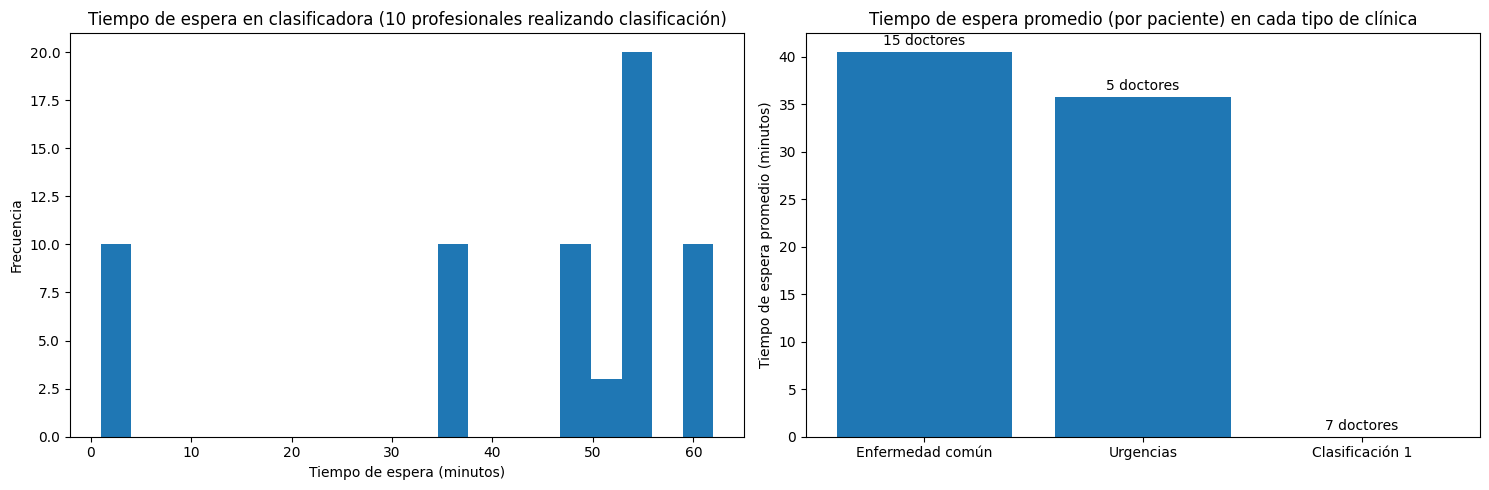

In [52]:
num_clinicas_clasificacion1 = 7
num_clinicas_clasificadoras = 10
num_clinicas_urgencias = 5
num_clinicas_comunes = 25


model = HospitalModel(65, num_clinicas_clasificacion1, num_clinicas_urgencias, num_clinicas_comunes, num_clinicas_clasificadoras)

for i in range(1440):  
    model.step()

model.reporte()

# Creación de la figura y los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Grafica: Tiempo de espera en clasificadora (pacientes que no llegaron en ambulancia)
tiempos_espera_clasificadora = [p.tiempo_espera_clasificadora for p in model.schedule.agents if not p.en_ambulancia]
ax1.hist(tiempos_espera_clasificadora, bins=20)
ax1.set_xlabel("Tiempo de espera (minutos)")
ax1.set_ylabel("Frecuencia")
ax1.set_title("Tiempo de espera en clasificadora (10 profesionales realizando clasificación)")

# Grafica: Barras de tiempo promedio de espera en cada tipo de clínica
tiempos_espera_clinicas = [model.tiempo_espera_enfermedad_comun/model.pacientes_enfermedad_comun, model.tiempo_espera_urgencias/model.pacientes_urgencias, model.tiempo_espera_clasificacion_1/model.pacientes_clasificacion_1]
doctores_por_clinica = [15, 5, 7]

barras = ax2.bar(["Enfermedad común", "Urgencias", "Clasificación 1"], tiempos_espera_clinicas)
ax2.set_ylabel("Tiempo de espera promedio (minutos)")
ax2.set_title("Tiempo de espera promedio (por paciente) en cada tipo de clínica")

# Anotaciones de la cantidad de doctores por clínica
for barra, doctores in zip(barras, doctores_por_clinica):
    altura = barra.get_height()
    ax2.annotate(f'{doctores} doctores',
                 xy=(barra.get_x() + barra.get_width() / 2, altura),
                 xytext=(0, 3),  # 3 puntos de desplazamiento vertical
                 textcoords="offset points",
                 ha='center', va='bottom')

# Mostrar la figura completa
plt.tight_layout()
plt.show()

Si el hospital promedio de EEUU atendiera a 400 pacientes diarios, nuevamente se pueden observar largos tiempos de espera similares a los del Hospital Roosevelt. Esto se debe a que la cantidad de doctores no es suficiente para atender a todos los pacientes de forma rápida y eficiente.

Pacientes atendidos: 
1. Cantidad de pacientes clasificados: 389
2. Cantidad de pacientes de urgencias: 91
3. Cantidad de pacientes de enfermedad común: 286
4. Cantidad de pacientes de clasificación 1: 18

Tiempo de espera promedio (minutos): 
1. Promedio de tiempo de espera clasificadora: 70.2210796915167
2. Promedio de tiempo de espera enfermedad común: 70.0034965034965
3. Promedio de tiempo de espera urgencias: 71.02197802197803
4. Promedio de tiempo de espera clasificación 1: 61.333333333333336


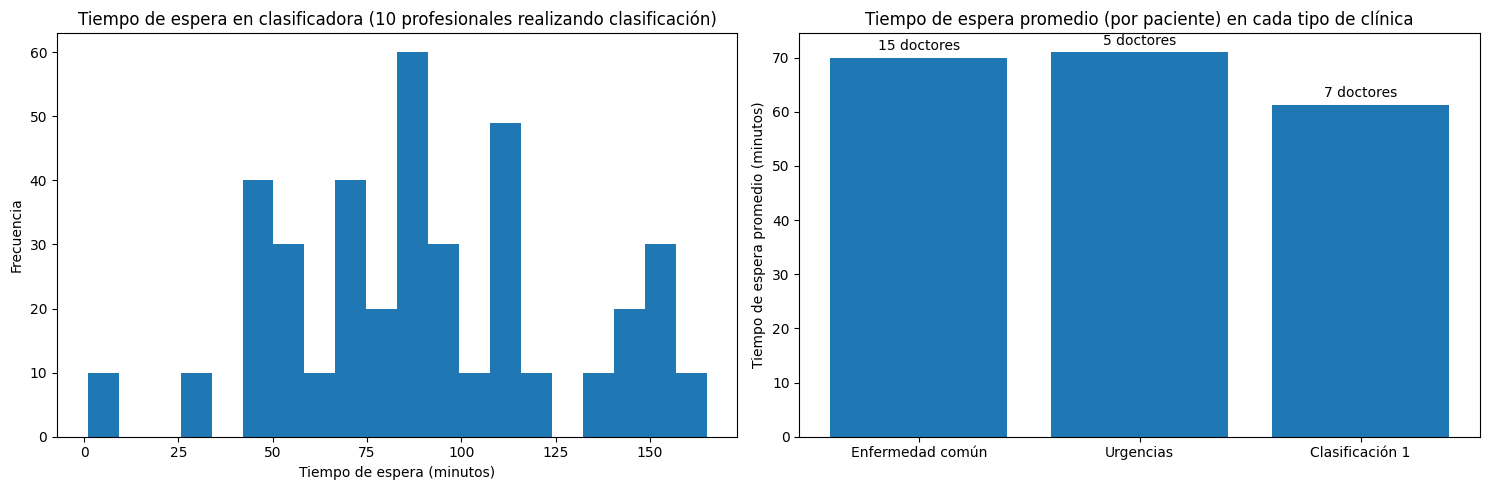

In [53]:
num_clinicas_clasificacion1 = 7
num_clinicas_clasificadoras = 10
num_clinicas_urgencias = 5
num_clinicas_comunes = 25


model = HospitalModel(400, num_clinicas_clasificacion1, num_clinicas_urgencias, num_clinicas_comunes, num_clinicas_clasificadoras)

for i in range(1440):  
    model.step()

model.reporte()

# Creación de la figura y los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Grafica: Tiempo de espera en clasificadora (pacientes que no llegaron en ambulancia)
tiempos_espera_clasificadora = [p.tiempo_espera_clasificadora for p in model.schedule.agents if not p.en_ambulancia]
ax1.hist(tiempos_espera_clasificadora, bins=20)
ax1.set_xlabel("Tiempo de espera (minutos)")
ax1.set_ylabel("Frecuencia")
ax1.set_title("Tiempo de espera en clasificadora (10 profesionales realizando clasificación)")

# Grafica: Barras de tiempo promedio de espera en cada tipo de clínica
tiempos_espera_clinicas = [model.tiempo_espera_enfermedad_comun/model.pacientes_enfermedad_comun, model.tiempo_espera_urgencias/model.pacientes_urgencias, model.tiempo_espera_clasificacion_1/model.pacientes_clasificacion_1]
doctores_por_clinica = [15, 5, 7]

barras = ax2.bar(["Enfermedad común", "Urgencias", "Clasificación 1"], tiempos_espera_clinicas)
ax2.set_ylabel("Tiempo de espera promedio (minutos)")
ax2.set_title("Tiempo de espera promedio (por paciente) en cada tipo de clínica")

# Anotaciones de la cantidad de doctores por clínica
for barra, doctores in zip(barras, doctores_por_clinica):
    altura = barra.get_height()
    ax2.annotate(f'{doctores} doctores',
                 xy=(barra.get_x() + barra.get_width() / 2, altura),
                 xytext=(0, 3),  # 3 puntos de desplazamiento vertical
                 textcoords="offset points",
                 ha='center', va='bottom')

# Mostrar la figura completa
plt.tight_layout()
plt.show()